In [1]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2 as cv
import re

In [2]:
def extract_position(input_name):
    # Use regex to find the 'Position' part
    match = re.search(r'Position \d+ - \d+_Z\d+_C\d+', input_name)
    if match:
        return match.group(0)
    else:
        return "Unknown_Position"

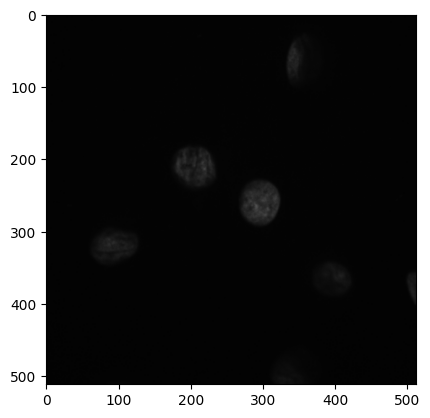

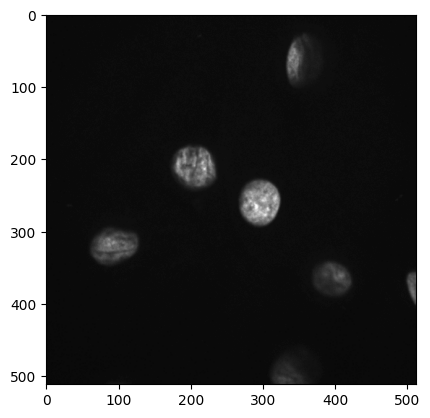

In [5]:
image = cv.imread('dapi1.tif')

new_image = np.zeros(image.shape, image.dtype)
## [basic-linear-transform-output]

alpha = 3.5
beta = 0

for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        for c in range(image.shape[2]):
            new_image[y,x,c] = np.clip(alpha*image[y,x,c] + beta, 0, 255)


plt.imshow(image)
plt.show()
plt.imshow(new_image)
plt.show()

In [1]:
folder1 = 'Images from Dellaire Lab/TIFF SAEC rep1 63x no As/C0'

In [4]:
folder2 = 'Images from Dellaire Lab/TIFF SAEC rep1 63x As High/C1'

In [5]:
output_folder = 'Images from Dellaire Lab/TIFF SAEC rep1 63x As High/merged-pml'

In [6]:
import os
import re
import cv2 as cv
import numpy as np
from pathlib import Path

def extract_z_info(filename):
    """Extract position and Z-stack information from filename."""
    # Match pattern like "Position 1 - 1_Z00_C1" or "Position 1_Z01_C1"
    match = re.search(r'Position (\d+(?:\s*-\s*\d+)?)[_ ](Z\d+)_(C\d+)', filename)
    
    if match:
        position = match.group(1).replace(' ', '')  # Remove spaces from position
        z_number = int(match.group(2)[1:])  # Extract number from Z00, Z01, etc.
        channel = match.group(3)
        return position, z_number, channel
    else:
        return None, None, None

def flatten_z_stacks(input_folder, output_folder):
    """
    Create flattened 2D images by combining all Z-projections for each position.
    """
    # Create output folder if it doesn't exist
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    
    # Get all .tif files
    all_files = [f for f in os.listdir(input_folder) if f.endswith('.tif')]
    print(f"\nTotal .tif files found: {len(all_files)}")
    
    if not all_files:
        raise ValueError(f"No .tif files found in {input_folder}")
    
    # Group files by position and channel
    position_stacks = {}
    for filename in all_files:
        position, z_number, channel = extract_z_info(filename)
        if position is not None:
            key = (position, channel)
            if key not in position_stacks:
                position_stacks[key] = []
            position_stacks[key].append((z_number, filename))
    
    # Print found positions and channels
    print(f"\nFound {len(position_stacks)} position-channel combinations:")
    for (pos, channel), files in position_stacks.items():
        print(f"Position {pos}, {channel}: {len(files)} Z-stacks")
    
    # Process each position-channel combination
    for (position, channel), files in position_stacks.items():
        print(f"\nProcessing Position {position}, {channel}")
        
        # Sort files by Z number
        files.sort()  # Will sort based on Z-number
        
        # Initialize variables for stack processing
        stack = []
        first_image = True
        
        # Process each Z-stack
        for z_number, filename in files:
            img_path = os.path.join(input_folder, filename)
            print(f"  Reading Z-stack {z_number}: {filename}")
            
            if os.path.exists(img_path):
                # Read image in original bit depth
                image = cv.imread(img_path, cv.IMREAD_UNCHANGED)
                
                if image is not None:
                    if first_image:
                        # Initialize image properties from first image
                        img_height, img_width = image.shape[:2]
                        first_image = False
                        
                    # Convert to float32 for processing
                    image = image.astype(np.float32)
                    
                    # Add to stack
                    stack.append(image)
                    print(f"    Successfully added to stack")
                else:
                    print(f"    Warning: Could not read image")
            else:
                print(f"    Warning: File not found")
        
        if stack:
            # Convert stack to numpy array
            stack = np.array(stack)
            print(f"  Processing stack of shape: {stack.shape}")
            
            # Create maximum intensity projection
            flattened = np.max(stack, axis=0)
            
            # Normalize the image
            flattened_min = np.min(flattened)
            flattened_max = np.max(flattened)
            if flattened_max > flattened_min:
                flattened = ((flattened - flattened_min) * 
                           (255.0 / (flattened_max - flattened_min)))
            
            # Convert to uint8
            flattened = flattened.astype(np.uint8)
            
            # Apply CLAHE for contrast enhancement
            clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            enhanced = clahe.apply(flattened)
            
            # Save both versions
            base_output = f"flattened_position_{position}_{channel}"
            
            # Save original flattened image
            output_path = os.path.join(output_folder, f"{base_output}.tif")
            cv.imwrite(output_path, flattened)
            print(f"Saved flattened image: {output_path}")
            
            # Save enhanced version
            enhanced_path = os.path.join(output_folder, f"{base_output}_enhanced.tif")
            cv.imwrite(enhanced_path, enhanced)
            print(f"Saved enhanced version: {enhanced_path}")
            
            # Create and save a color-coded depth map
            z_indices = np.argmax(stack, axis=0)
            depth_map = ((z_indices.astype(float) / (len(stack) - 1)) * 255).astype(np.uint8)
            depth_map_colored = cv.applyColorMap(depth_map, cv.COLORMAP_JET)
            depth_path = os.path.join(output_folder, f"{base_output}_depth_map.tif")
            cv.imwrite(depth_path, depth_map_colored)
            print(f"Saved depth map: {depth_path}")
            
        else:
            print(f"Warning: No valid images found for Position {position}, {channel}")

# Example usage
if __name__ == "__main__":
    input_folder = folder2  # Replace with your input folder path
    output_folder = output_folder  # Replace with your output folder path
    
    try:
        flatten_z_stacks(input_folder, output_folder)
    except Exception as e:
        print(f"Error: {str(e)}")


Total .tif files found: 1480

Found 40 position-channel combinations:
Position 10, C1: 37 Z-stacks
Position 11, C1: 37 Z-stacks
Position 12, C1: 37 Z-stacks
Position 13, C1: 37 Z-stacks
Position 14, C1: 37 Z-stacks
Position 15, C1: 37 Z-stacks
Position 16, C1: 37 Z-stacks
Position 17, C1: 37 Z-stacks
Position 18, C1: 37 Z-stacks
Position 19, C1: 37 Z-stacks
Position 1, C1: 37 Z-stacks
Position 20, C1: 37 Z-stacks
Position 21, C1: 37 Z-stacks
Position 22, C1: 37 Z-stacks
Position 23, C1: 37 Z-stacks
Position 24, C1: 37 Z-stacks
Position 25, C1: 37 Z-stacks
Position 26, C1: 37 Z-stacks
Position 27, C1: 37 Z-stacks
Position 28, C1: 37 Z-stacks
Position 29, C1: 37 Z-stacks
Position 2, C1: 37 Z-stacks
Position 30, C1: 37 Z-stacks
Position 31, C1: 37 Z-stacks
Position 32, C1: 37 Z-stacks
Position 33, C1: 37 Z-stacks
Position 34, C1: 37 Z-stacks
Position 35, C1: 37 Z-stacks
Position 36, C1: 37 Z-stacks
Position 37, C1: 37 Z-stacks
Position 38, C1: 37 Z-stacks
Position 39, C1: 37 Z-stacks
Pos

In [6]:
images1 = sorted(os.listdir(folder1))
images2 = sorted(os.listdir(folder2))

alpha = 3.5
beta = 0

for img1_name , img2_name in zip(images1,images2):
    img_path = 'Images from Dellaire Lab/TIFF SAEC rep1 63x no As/C0/' + img1_name
    print(img_path)
    image = cv.imread(img_path)

    new_image = np.zeros(image.shape, image.dtype)
    ## [basic-linear-transform-output]

    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            for c in range(image.shape[2]):
                new_image[y,x,c] = np.clip(alpha*image[y,x,c] + beta, 0, 255)

    position = extract_position(img_path)
    print(position)
    cv.imwrite(f'Images from Dellaire Lab/TIFF SAEC rep1 63x no As/dapi_new/transformed_dapi - {position}.jpg', new_image)
    
    


Images from Dellaire Lab/TIFF SAEC rep1 63x no As/C0/SAEC exp1 no As 63x - Position 1 - 1_Z00_C0.tif
Position 1 - 1_Z00_C0
Images from Dellaire Lab/TIFF SAEC rep1 63x no As/C0/SAEC exp1 no As 63x - Position 1 - 1_Z01_C0.tif
Position 1 - 1_Z01_C0
Images from Dellaire Lab/TIFF SAEC rep1 63x no As/C0/SAEC exp1 no As 63x - Position 1 - 1_Z02_C0.tif
Position 1 - 1_Z02_C0
Images from Dellaire Lab/TIFF SAEC rep1 63x no As/C0/SAEC exp1 no As 63x - Position 1 - 1_Z03_C0.tif
Position 1 - 1_Z03_C0
Images from Dellaire Lab/TIFF SAEC rep1 63x no As/C0/SAEC exp1 no As 63x - Position 1 - 1_Z04_C0.tif
Position 1 - 1_Z04_C0
Images from Dellaire Lab/TIFF SAEC rep1 63x no As/C0/SAEC exp1 no As 63x - Position 1 - 1_Z05_C0.tif
Position 1 - 1_Z05_C0
Images from Dellaire Lab/TIFF SAEC rep1 63x no As/C0/SAEC exp1 no As 63x - Position 1 - 1_Z06_C0.tif
Position 1 - 1_Z06_C0
Images from Dellaire Lab/TIFF SAEC rep1 63x no As/C0/SAEC exp1 no As 63x - Position 1 - 1_Z07_C0.tif
Position 1 - 1_Z07_C0
Images from Dell

KeyboardInterrupt: 

In [ ]:

alpha = 1.0
alpha_max = 500
beta = 0
beta_max = 200
gamma = 1.0
gamma_max = 200

def basicLinearTransform():
    res = cv.convertScaleAbs(img_original, alpha=alpha, beta=beta)
    img_corrected = cv.hconcat([img_original, res])
    cv.imshow("Brightness and contrast adjustments", img_corrected)

def gammaCorrection():
    ## [changing-contrast-brightness-gamma-correction]
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)

    res = cv.LUT(img_original, lookUpTable)
    ## [changing-contrast-brightness-gamma-correction]

    img_gamma_corrected = cv.hconcat([img_original, res])
    cv.imshow("Gamma correction", img_gamma_corrected)

def on_linear_transform_alpha_trackbar(val):
    global alpha
    alpha = val / 100
    basicLinearTransform()

def on_linear_transform_beta_trackbar(val):
    global beta
    beta = val - 100
    basicLinearTransform()

def on_gamma_correction_trackbar(val):
    global gamma
    gamma = val / 100
    gammaCorrection()



img_original = cv.imread('dapi1.tif')


img_corrected = np.empty((img_original.shape[0], img_original.shape[1]*2, img_original.shape[2]), img_original.dtype)
img_gamma_corrected = np.empty((img_original.shape[0], img_original.shape[1]*2, img_original.shape[2]), img_original.dtype)

img_corrected = cv.hconcat([img_original, img_original])
img_gamma_corrected = cv.hconcat([img_original, img_original])

cv.namedWindow('Brightness and contrast adjustments')
cv.namedWindow('Gamma correction')

alpha_init = int(alpha *100)
cv.createTrackbar('Alpha gain (contrast)', 'Brightness and contrast adjustments', alpha_init, alpha_max, on_linear_transform_alpha_trackbar)
beta_init = beta + 100
cv.createTrackbar('Beta bias (brightness)', 'Brightness and contrast adjustments', beta_init, beta_max, on_linear_transform_beta_trackbar)
gamma_init = int(gamma * 100)
cv.createTrackbar('Gamma correction', 'Gamma correction', gamma_init, gamma_max, on_gamma_correction_trackbar)

on_linear_transform_alpha_trackbar(alpha_init)
on_gamma_correction_trackbar(gamma_init)

cv.waitKey()

In [ ]:
plt.imshow(merged)
plt.show()

In [ ]:
img1_path = os.path.join(folder1, img1_name)
    img2_path = os.path.join(folder2, img2_name)
    print(img1_path)
    print(img2_path)
    image1 = Image.open(img1_path)
    image2 = Image.open(img2_path)
    print(image1.mode)
    print(image2.mode)
    img1_rgba = image1.convert('rgba')
    img2_rgba = image2.convert('rgba')
    
    plt.imshow(img1_rgba)
    plt.show()
    plt.imshow(img2_rgba)
    plt.show()
    jittered_image1 = color_jitter(img1_rgba)
    jittered_image2 = color_jitter(img2_rgba)
    merged_image = Image.blend(jittered_image1,jittered_image2,alpha)
    output_image_path = os.path.join(output_folder, f"merged_{img1_name}")
    merged_image.save(output_image_path)
    print(f"Saved merged image: {output_image_path}")